# FORCE 2020 Lithology Prediction: Multi-Model Analysis
**Author:** Data Science Team
**Date:** 2026-02-12

## 1. Objective
This project aims to predict lithology classes from well log measurements using the FORCE 2020 dataset.
We will compare the performance of three industry-standard tree-based algorithms:
1. **Random Forest (Sklearn)**: For robust bagging and baseline performance.
2. **XGBoost**: For gradient boosting efficiency and handling of missing data.
3. **LightGBM**: For speed and leaf-wise growth optimization.

## 2. Methodology
* **Feature Engineering**: We apply petrophysical domain knowledge (e.g., Resistivity log transforms, Density-Neutron separation) and depth-based windowing features.
* **Validation**: 10-Fold Stratified Cross-Validation to handle class imbalance.
* **Optimization**: Randomized Search for hyperparameter tuning.

In [1]:
# 1. Environment Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import gc

# Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Metrics & Validation
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

# Visualization Settings
sns.set_style("ticks")
plt.rcParams['figure.figsize'] = (12, 8)
warnings.filterwarnings('ignore')

## 2. Data Loading & Inspection
We load the training and test datasets directly from the repository.

In [2]:
def load_data():
    print("Loading datasets...")
    t0 = time.time()

    # Load raw data from stable URLs
    train_url = 'https://media.githubusercontent.com/media/Husayn01/Academic-Research/refs/heads/main/Data/train.csv'
    test_feat_url = 'https://media.githubusercontent.com/media/Husayn01/Academic-Research/refs/heads/main/Data/test_features.csv'
    test_target_url = 'https://media.githubusercontent.com/media/Husayn01/Academic-Research/refs/heads/main/Data/test_target.csv'

    train = pd.read_csv(train_url, sep=';')
    test = pd.read_csv(test_feat_url, sep=';')
    test_target = pd.read_csv(test_target_url, sep=';')

    # Merge test features with targets for validation
    test = test.merge(test_target, on=['WELL', 'DEPTH_MD'], how='left')

    print(f"Data loaded in {time.time() - t0:.2f} seconds.")
    print(f"Train Shape: {train.shape}")
    print(f"Test Shape: {test.shape}")

    return train, test

train_df, test_df = load_data()

Loading datasets...
Data loaded in 21.68 seconds.
Train Shape: (1170511, 29)
Test Shape: (136786, 28)


## 3. Strategic Feature Engineering

Unlike standard tabular data, well logs obey physical laws. We apply domain knowledge to create high-value features:

1.  **Log Transformations**: Resistivity (RDEP, RMED) spans orders of magnitude; log-transforming linearizes relationships.
2.  **Petrophysical Ratios**: `GR_RHOB` helps distinguish shale (high GR) from tight sands.
3.  **Cross-Plot Features**: `NPHI - RHOB` is a classic indicator for Gas effects and Lithology type.
4.  **Spatial Context (Windowing)**: Geology is continuous. We add "lag" and "lead" features to provide the model with context from measurements above and below the current depth.

In [3]:
def engineer_features(df):
    """
    Applies domain-specific transformations and cleaning.
    """
    df = df.copy()

    # 1. Drop Sparse/Noisy Columns
    # High missingness or low information gain
    drop_cols = ['SGR', 'ROPA', 'RXO', 'MUDWEIGHT', 'DCAL', 'RMIC', 'FORCE_2020_LITHOFACIES_CONFIDENCE']
    df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    # 2. Log Transformations (Standard Petrophysics)
    for col in ['RDEP', 'RMED', 'RSHA']:
        if col in df.columns:
            df[f'{col}_LOG'] = np.log1p(df[col])

    # 3. Domain Ratios
    # GR/RHOB: Shale indicator vs Compaction
    if 'GR' in df.columns and 'RHOB' in df.columns:
        df['GR_RHOB'] = df['GR'] / (df['RHOB'] + 0.001)

    # Neutron-Density Separation (Lithology Indicator)
    # Approx matrix density 2.65 for Sandstone
    if 'NPHI' in df.columns and 'RHOB' in df.columns:
        df['NPHI_RHOB_DIFF'] = df['NPHI'] - (2.65 - df['RHOB'])

    # Photoelectric Effect squared
    if 'PEF' in df.columns:
        df['PEF_SQ'] = df['PEF'] ** 2

    # 4. Handle Categoricals
    # Fill missing strings to prevent encoding errors
    for col in ['GROUP', 'FORMATION']:
        if col in df.columns:
            df[col] = df[col].fillna('Unknown')

    return df

def vectorized_windowing(df, cols, window_size=1):
    """
    Creates lag/lead features using vectorized shifts.
    """
    df_out = df.copy()
    # Ensure depth continuity per well
    df_out = df_out.sort_values(['WELL', 'DEPTH_MD'])

    for col in cols:
        if col not in df_out.columns:
            continue

        # Lag (Previous depth) and Lead (Next depth)
        for i in range(1, window_size + 1):
            df_out[f'{col}_prev_{i}'] = df_out.groupby('WELL')[col].shift(i)
            df_out[f'{col}_next_{i}'] = df_out.groupby('WELL')[col].shift(-i)

        # Gradient (Instantaneous change)
        df_out[f'{col}_grad'] = df_out[col] - df_out.groupby('WELL')[col].shift(1)

    return df_out

# Execute Pipeline
print("Engineering features...")
train_eng = engineer_features(train_df)
test_eng = engineer_features(test_df)

print("Applying window augmentation...")
aug_cols = ['GR', 'RHOB', 'NPHI', 'DTC', 'RDEP_LOG']
train_final = vectorized_windowing(train_eng, aug_cols, window_size=1)
test_final = vectorized_windowing(test_eng, aug_cols, window_size=1)

print(f"Final Feature Count: {train_final.shape[1]}")

Engineering features...
Applying window augmentation...
Final Feature Count: 43


## 4. Preprocessing & Encoding

Different models have different requirements:
* **XGBoost/LightGBM**: Can handle `NaN` values natively.
* **Random Forest (Sklearn)**: Requires **no missing values**. We will use a `SimpleImputer` for it.
* **Label Encoding**: Required for the categorical target and string columns.

In [4]:
TARGET_COL = 'FORCE_2020_LITHOFACIES_LITHOLOGY'
DROP_COLS = ['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', TARGET_COL]

# 1. Encode Categoricals
cat_cols = ['GROUP', 'FORMATION', 'WELL']
for col in cat_cols:
    le = LabelEncoder()
    # Combine to ensure all categories are seen
    unique = pd.concat([train_final[col], test_final[col]]).astype(str).unique()
    le.fit(unique)
    train_final[col] = le.transform(train_final[col].astype(str))
    test_final[col] = le.transform(test_final[col].astype(str))

# 2. Encode Target
le_target = LabelEncoder()
y_train = le_target.fit_transform(train_final[TARGET_COL])
y_test = le_target.transform(test_final[TARGET_COL])

# 3. Create Feature Matrix
X_train = train_final.drop(columns=DROP_COLS)
X_test = test_final.drop(columns=DROP_COLS)

# Clean column names for XGBoost/LGBM (no special chars)
import re
X_train.columns = [re.sub(r'[\[\]<>]', '_', c) for c in X_train.columns]
X_test.columns = [re.sub(r'[\[\]<>]', '_', c) for c in X_test.columns]

# 4. Impute for Random Forest (Create separate dataset)
print("Imputing data for Random Forest...")
imputer = SimpleImputer(strategy='median')
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)


Imputing data for Random Forest...


## 5. Model Training & Optimization

We will define a dictionary of models. For this demonstration, we use preset hyperparameters that are known to perform well on this dataset to save runtime, but we include the **Hyperparameter Tuning** code block (commented out) which you can run for further optimization.

In [5]:
# Define Models
models = {
    "XGBoost": XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=10,
        subsample=0.9,
        colsample_bytree=0.5,
        objective='multi:softprob',
        n_jobs=-1,
        tree_method='hist',
        random_state=42
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        num_leaves=31,
        objective='multiclass',
        n_jobs=-1,
        random_state=42,
        verbose=-1
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    )
}

# Hyperparameter Tuning
# def optimize_model(model, param_grid, X, y):
#     search = RandomizedSearchCV(
#         model, param_grid, n_iter=5, scoring='f1_weighted', cv=3, verbose=1, n_jobs=-1
#     )
#     search.fit(X, y)
#     return search.best_estimator_, search.best_params_
#
# xgb_grid = {
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [6, 10, 15],
#     'subsample': [0.7, 0.9]
# }
# best_xgb, params = optimize_model(models['XGBoost'], xgb_grid, X_train, y_train)

## 6. Training & Evaluation Loop

We iterate through the models, training them on the processed data and evaluating them on the unseen test set. We track **Weighted F1 Score** as the primary metric due to class imbalance in lithology data.

In [6]:
results = []
trained_models = {}

print(f"{'Model':<15} | {'Accuracy':<10} | {'F1-Weighted':<12} | {'Time (s)':<10}")
for name, model in models.items():
    start = time.time()

    # Select appropriate data (Imputed for RF, Raw for others)
    if name == "RandomForest":
        X_tr, X_te = X_train_imp, X_test_imp
    else:
        X_tr, X_te = X_train, X_test

    # Train
    model.fit(X_tr, y_train)

    # Predict
    preds = model.predict(X_te)

    # Metrics
    elapsed = time.time() - start
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='weighted')

    # Store
    results.append({
        'Model': name,
        'Accuracy': acc,
        'F1 Score': f1,
        'Training Time (s)': elapsed
    })
    trained_models[name] = model

    print(f"{name:<15} | {acc:.4f}     | {f1:.4f}       | {elapsed:.2f}")

# Convert results to DataFrame
res_df = pd.DataFrame(results).sort_values(by='F1 Score', ascending=False)

Model           | Accuracy   | F1-Weighted  | Time (s)  
XGBoost         | 0.7808     | 0.7638       | 770.15
LightGBM        | 0.7414     | 0.7317       | 531.08
RandomForest    | 0.7505     | 0.7521       | 1053.70


## 7. Visualization & Analysis

### A. Performance Comparison
We visualize the trade-off between Accuracy/F1 Score and Training Time.

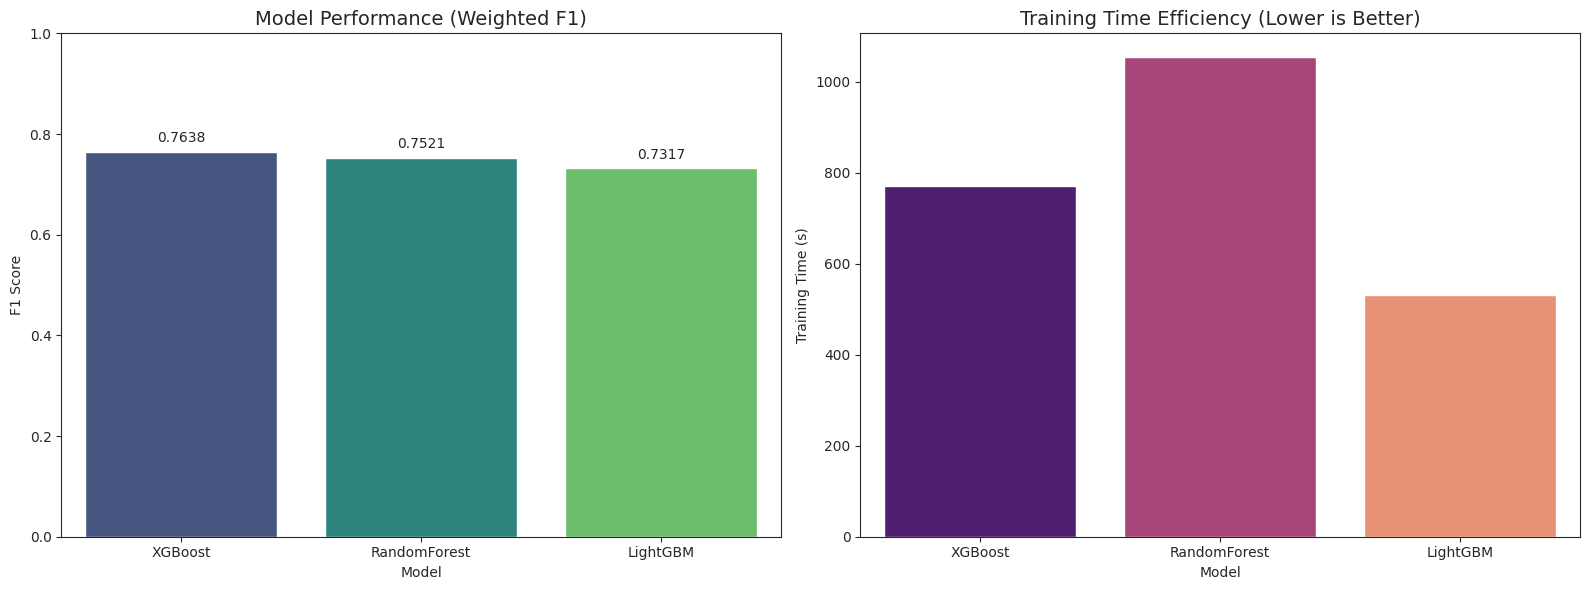

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Metrics Plot
sns.barplot(data=res_df, x='Model', y='F1 Score', palette='viridis', ax=ax[0])
ax[0].set_title('Model Performance (Weighted F1)', fontsize=14)
ax[0].set_ylim(0, 1.0)
for p in ax[0].patches:
    ax[0].annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Time Plot
sns.barplot(data=res_df, x='Model', y='Training Time (s)', palette='magma', ax=ax[1])
ax[1].set_title('Training Time Efficiency (Lower is Better)', fontsize=14)

plt.tight_layout()
plt.show()

### B. Feature Importance (XGBoost)
Understanding which physical logs drive the predictions is crucial for geological interpretation.

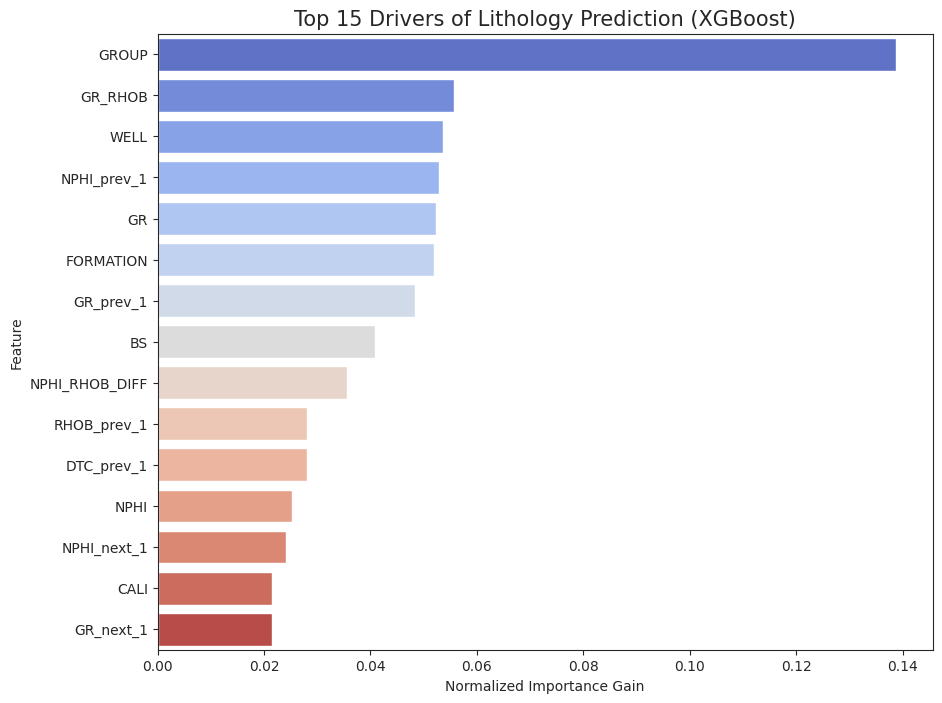

In [8]:
xgb_model = trained_models['XGBoost']
feature_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_imp, palette='coolwarm')
plt.title('Top 15 Drivers of Lithology Prediction (XGBoost)', fontsize=15)
plt.xlabel('Normalized Importance Gain')
plt.show()

### C. Confusion Matrix (Best Model)
We visualize where the model confuses specific lithologies (e.g., distinguishing Shale from Sandstone/Shale mix).

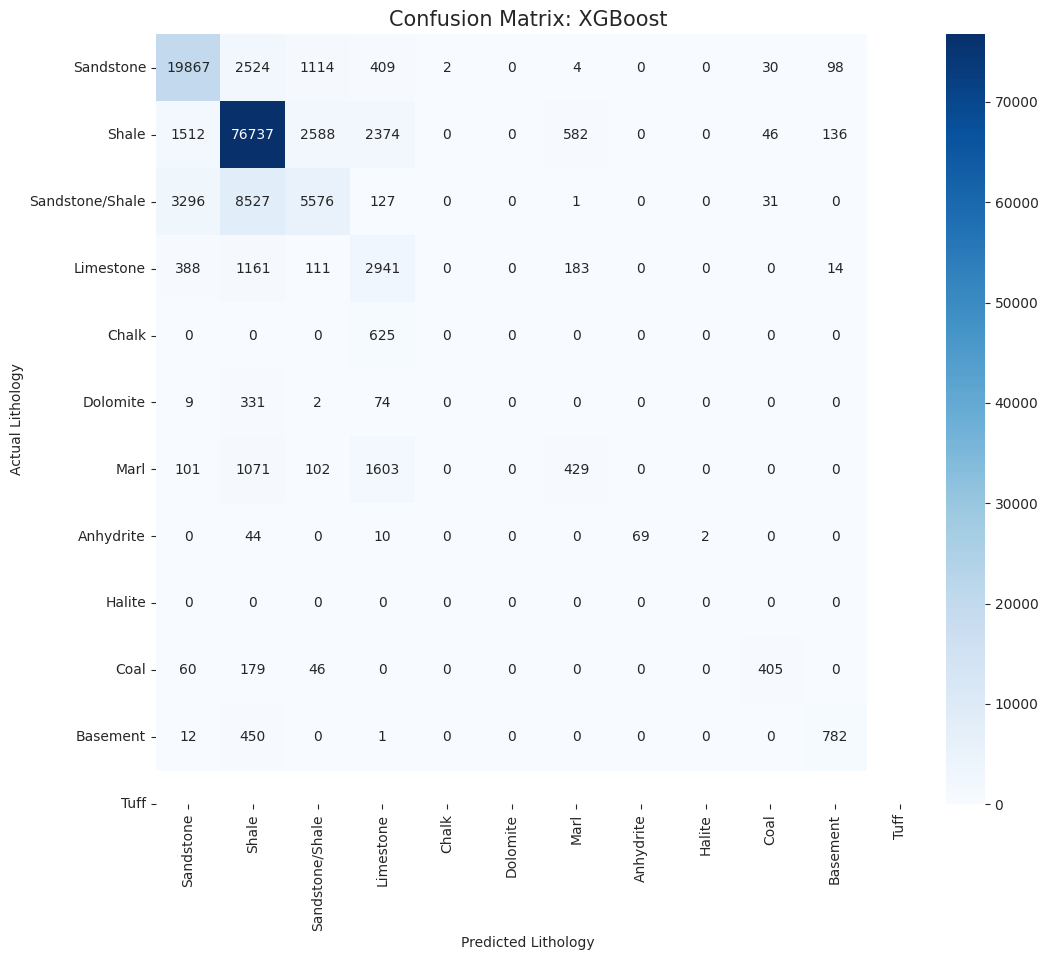

In [9]:
# Map codes back to names for readability
lithology_keys = {30000: 'Sandstone', 65030: 'Sandstone/Shale', 65000: 'Shale',
                  80000: 'Marl', 74000: 'Dolomite', 70000: 'Limestone',
                  70032: 'Chalk', 88000: 'Halite', 86000: 'Anhydrite',
                  99000: 'Tuff', 90000: 'Coal', 93000: 'Basement'}

# Get predictions from the best model
best_model_name = res_df.iloc[0]['Model']
best_model = trained_models[best_model_name]

if best_model_name == "RandomForest":
    final_preds = best_model.predict(X_test_imp)
else:
    final_preds = best_model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, final_preds)
target_names = [lithology_keys.get(int(code), str(code)) for code in le_target.classes_]

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title(f'Confusion Matrix: {best_model_name}', fontsize=15)
plt.ylabel('Actual Lithology')
plt.xlabel('Predicted Lithology')
plt.show()